In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import gzip
import gensim.downloader as genapi
import sys
import pickle
import random
import gensim.downloader as genapi
from gensim.models import KeyedVectors 
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import os
import matplotlib.pyplot as plt
import time
import copy


In [ ]:
!tar xvf text_datasets_for_DLStudio.tar.gz

data/
data/sentiment_dataset_test_3.tar.gz
data/sentiment_dataset_test_40.tar.gz
data/sentiment_dataset_train_3.tar.gz
data/sentiment_dataset_test_200.tar.gz
data/sentiment_dataset_test_400.tar.gz
data/sentiment_dataset_train_40.tar.gz
data/sentiment_dataset_train_200.tar.gz
data/sentiment_dataset_train_400.tar.gz


In [ ]:
class SentimentAnalysisDataLoader(torch.utils.data.Dataset):
    def __init__(self, dataroot, train_or_test, dataset_file, path_to_saved_embeddings=None):
        super().__init__()
        import gensim.downloader as gen_api
#                self.word_vectors = gen_api.load("word2vec-google-news-300")
        self.path_to_saved_embeddings = path_to_saved_embeddings
        self.train_or_test = train_or_test
        root_dir = dataroot
        f = gzip.open(root_dir + dataset_file, 'rb')
        dataset = f.read()
        if path_to_saved_embeddings is not None:
            import gensim.downloader as genapi
            from gensim.models import KeyedVectors 
            if os.path.exists(path_to_saved_embeddings + 'vectors.kv'):
                self.word_vectors = KeyedVectors.load(path_to_saved_embeddings + 'vectors.kv')
            else:
                print("""\n\nSince this is your first time to install the word2vec embeddings, it may take"""
                      """\na couple of minutes. The embeddings occupy around 3.6GB of your disk space.\n\n""")
                self.word_vectors = genapi.load("word2vec-google-news-300")               
                ##  'kv' stands for  "KeyedVectors", a special datatype used by gensim because it 
                ##  has a smaller footprint than dict
                self.word_vectors.save(path_to_saved_embeddings + 'vectors.kv')    
        if train_or_test == 'train':
            if sys.version_info[0] == 3:
                self.positive_reviews_train, self.negative_reviews_train, self.vocab = pickle.loads(dataset, encoding='latin1')
            else:
                self.positive_reviews_train, self.negative_reviews_train, self.vocab = pickle.loads(dataset)
            self.categories = sorted(list(self.positive_reviews_train.keys()))
            self.category_sizes_train_pos = {category : len(self.positive_reviews_train[category]) for category in self.categories}
            self.category_sizes_train_neg = {category : len(self.negative_reviews_train[category]) for category in self.categories}
            self.indexed_dataset_train = []
            for category in self.positive_reviews_train:
                for review in self.positive_reviews_train[category]:
                    self.indexed_dataset_train.append([review, category, 1])
            for category in self.negative_reviews_train:
                for review in self.negative_reviews_train[category]:
                    self.indexed_dataset_train.append([review, category, 0])
            random.shuffle(self.indexed_dataset_train)
        elif train_or_test == 'test':
            if sys.version_info[0] == 3:
                self.positive_reviews_test, self.negative_reviews_test, self.vocab = pickle.loads(dataset, encoding='latin1')
            else:
                self.positive_reviews_test, self.negative_reviews_test, self.vocab = pickle.loads(dataset)
            self.vocab = sorted(self.vocab)
            self.categories = sorted(list(self.positive_reviews_test.keys()))
            self.category_sizes_test_pos = {category : len(self.positive_reviews_test[category]) for category in self.categories}
            self.category_sizes_test_neg = {category : len(self.negative_reviews_test[category]) for category in self.categories}
            self.indexed_dataset_test = []
            for category in self.positive_reviews_test:
                for review in self.positive_reviews_test[category]:
                    self.indexed_dataset_test.append([review, category, 1])
            for category in self.negative_reviews_test:
                for review in self.negative_reviews_test[category]:
                    self.indexed_dataset_test.append([review, category, 0])
            random.shuffle(self.indexed_dataset_test)

    def review_to_tensor(self, review):
        list_of_embeddings = []
        for i,word in enumerate(review):
            if word in self.word_vectors.key_to_index:
                embedding = self.word_vectors[word]
                list_of_embeddings.append(np.array(embedding))
            else:
                next
        review_tensor = torch.FloatTensor( list_of_embeddings )
        return review_tensor

    def sentiment_to_tensor(self, sentiment):
        sentiment_tensor = torch.zeros(2)
        if sentiment == 1:
            sentiment_tensor[1] = 1
        elif sentiment == 0: 
            sentiment_tensor[0] = 1
        sentiment_tensor = sentiment_tensor.type(torch.long)
        return sentiment_tensor

    def __len__(self):
        if self.train_or_test == 'train':
            return len(self.indexed_dataset_train)
        elif self.train_or_test == 'test':
            return len(self.indexed_dataset_test)

    def __getitem__(self, idx):
        sample = self.indexed_dataset_train[idx] if self.train_or_test == 'train' else self.indexed_dataset_test[idx]
        review = sample[0]
        review_category = sample[1]
        review_sentiment = sample[2]
        review_sentiment = self.sentiment_to_tensor(review_sentiment)
        review_tensor = self.review_to_tensor(review)
        category_index = self.categories.index(review_category)
        sample = {'review'       : review_tensor, 
                  'category'     : category_index, # should be converted to tensor, but not yet used
                  'sentiment'    : review_sentiment }
        return sample

In [ ]:
dataroot = './'
dataset_archive_test = "data/sentiment_dataset_test_400.tar.gz"
path_to_saved_embeddings = './'
batch_size = 10
path_saved_model = './net.pth'


dataserver_test = SentimentAnalysisDataLoader(dataroot, train_or_test = 'test',dataset_file = dataset_archive_test,
                                 path_to_saved_embeddings = path_to_saved_embeddings)
test_dataloader = torch.utils.data.DataLoader(dataserver_test,batch_size=batch_size,shuffle=False, num_workers=2)

In [ ]:
class GRUnetWithEmbeddings(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1): 
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers , bidirectional = True)
        self.fc = nn.Linear(hidden_size*2, output_size)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        #print(out.shape)
        #print(h.shape)
        out = self.fc(self.relu(out[:,-1]))
        out = self.logsoftmax(out)
        
        return out, h

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new( 4, 1,  self.hidden_size ).zero_()
        return hidden

In [ ]:
def run_code_for_training_for_text_classification_with_GRU_word2vec(net, display_train_loss, learning_rate): 
    filename_for_out = "performance_numbers_" + str(epochs) + ".txt"
    FILE = open(filename_for_out, 'w')
    net = copy.deepcopy(net)
    net = net.to(device)
    ##  Note that the GREnet now produces the LogSoftmax output:
    criterion = nn.NLLLoss()
    accum_times = []
    optimizer = optim.Adam(net.parameters(), lr=0.0005, betas=(0.5, 0.999))
    training_loss_tally = []
    start_time = time.perf_counter()
    for epoch in range(epochs):  
        print("")
        running_loss = 0.0
        for i, data in enumerate(train_dataloader):    
            review_tensor,category,sentiment = data['review'], data['category'], data['sentiment']
            review_tensor = review_tensor.to(device)
            sentiment = sentiment.to(device)
            ## The following type conversion needed for MSELoss:
            ##sentiment = sentiment.float()
            optimizer.zero_grad()
            hidden = net.init_hidden().to(device)
            for k in range(review_tensor.shape[1]):
                output, hidden = net(torch.unsqueeze(torch.unsqueeze(review_tensor[0,k],0),0), hidden)
            loss = criterion(output, torch.argmax(sentiment, 1))
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            if i % 200 == 199:    
                avg_loss = running_loss / float(200)
                training_loss_tally.append(avg_loss)
                current_time = time.perf_counter()
                time_elapsed = current_time-start_time
                print("[epoch:%d  iter:%4d  elapsed_time:%4d secs]     loss: %.5f" % (epoch+1,i+1, time_elapsed,avg_loss))
                accum_times.append(current_time-start_time)
                FILE.write("%.5f\n" % avg_loss)
                FILE.flush()
                running_loss = 0.0
    torch.save(net, 'net.pth')
    print("Total Training Time: {}".format(str(sum(accum_times))))
    print("\nFinished Training\n\n")
    if display_train_loss:
        plt.figure(figsize=(10,5))
        plt.title("Training Loss vs. Iterations")
        plt.plot(training_loss_tally)
        plt.xlabel("iterations")
        plt.ylabel("training loss")
        plt.legend()
        plt.savefig("training_loss.png")
        plt.show()


[epoch:1  iter: 200  elapsed_time:  17 secs]     loss: 0.69682
[epoch:1  iter: 400  elapsed_time:  36 secs]     loss: 0.67510
[epoch:1  iter: 600  elapsed_time:  54 secs]     loss: 0.66102
[epoch:1  iter: 800  elapsed_time:  73 secs]     loss: 0.68487
[epoch:1  iter:1000  elapsed_time:  91 secs]     loss: 0.62272
[epoch:1  iter:1200  elapsed_time: 111 secs]     loss: 0.63797
[epoch:1  iter:1400  elapsed_time: 127 secs]     loss: 0.64466
[epoch:1  iter:1600  elapsed_time: 146 secs]     loss: 0.66140
[epoch:1  iter:1800  elapsed_time: 163 secs]     loss: 0.71000
[epoch:1  iter:2000  elapsed_time: 180 secs]     loss: 0.68685
[epoch:1  iter:2200  elapsed_time: 198 secs]     loss: 0.58416
[epoch:1  iter:2400  elapsed_time: 217 secs]     loss: 0.55019
[epoch:1  iter:2600  elapsed_time: 234 secs]     loss: 0.58293
[epoch:1  iter:2800  elapsed_time: 252 secs]     loss: 0.56776
[epoch:1  iter:3000  elapsed_time: 272 secs]     loss: 0.50800
[epoch:1  iter:3200  elapsed_time: 289 secs]     loss:

Total Training Time: 1197645.886385218

Finished Training




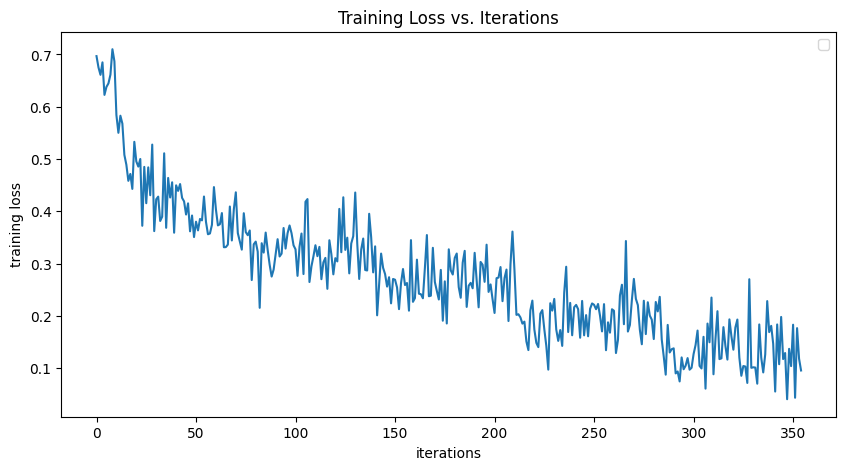

In [ ]:
    dataroot = './'
    dataset_archive_train = "data/sentiment_dataset_train_400.tar.gz"
    path_to_saved_embeddings = './'
    momentum = 0.9
    learning_rate =  1e-3
    epochs = 5
    batch_size = 1
    classes = ('negative','positive')
    device = 'cuda'


    dataserver_train = SentimentAnalysisDataLoader(dataroot, train_or_test = 'train',dataset_file = dataset_archive_train,
                                 path_to_saved_embeddings = path_to_saved_embeddings)
    train_dataloader = torch.utils.data.DataLoader(dataserver_train,
                        batch_size=batch_size,shuffle=True, num_workers=0)
    
    model = GRUnetWithEmbeddings(input_size=300, hidden_size=300, output_size=2, num_layers=2)
    
    run_code_for_training_for_text_classification_with_GRU_word2vec(model, display_train_loss=True,learning_rate=learning_rate)

In [ ]:
def run_code_for_testing_text_classification_with_GRU_word2vec(net, test_dataloader):
    classification_accuracy = 0.0
    negative_total = 0
    positive_total = 0
    confusion_matrix = torch.zeros(2,2)
    net = net.to(device)
    with torch.no_grad():
        for i, data in enumerate(test_dataloader):
            review_tensor,category,sentiment = data['review'], data['category'], data['sentiment']
            review_tensor = review_tensor.to(device)
            category = category.to(device)
            sentiment = sentiment.to(device)
            hidden = net.init_hidden()
            for k in range(review_tensor.shape[1]):
                output, hidden = net(torch.unsqueeze(torch.unsqueeze(review_tensor[0,k],0),0), hidden)
            predicted_idx = torch.argmax(output).item()
            gt_idx = torch.argmax(sentiment).item()
            if i % 100 == 99:
                print("   [i=%d]    predicted_label=%d       gt_label=%d" % (i+1, predicted_idx,gt_idx))
            if predicted_idx == gt_idx:
                classification_accuracy += 1
            if gt_idx == 0: 
                negative_total += 1
            elif gt_idx == 1:
                positive_total += 1
            confusion_matrix[gt_idx,predicted_idx] += 1
    print("\nOverall classification accuracy: %0.2f%%" %  (float(classification_accuracy) * 100 /float(i)))
    out_percent = np.zeros((2,2), dtype='float')
    out_percent[0,0] = "%.3f" % (100 * confusion_matrix[0,0] / float(negative_total))
    out_percent[0,1] = "%.3f" % (100 * confusion_matrix[0,1] / float(negative_total))
    out_percent[1,0] = "%.3f" % (100 * confusion_matrix[1,0] / float(positive_total))
    out_percent[1,1] = "%.3f" % (100 * confusion_matrix[1,1] / float(positive_total))
    print("\n\nNumber of positive reviews tested: %d" % positive_total)
    print("\n\nNumber of negative reviews tested: %d" % negative_total)
    print("\n\nDisplaying the confusion matrix:\n")
    out_str = "                      "
    out_str +=  "%18s    %18s" % ('predicted negative', 'predicted positive')
    print(out_str + "\n")
    for i,label in enumerate(['true negative', 'true positive']):
        out_str = "%12s:  " % label
        for j in range(2):
            out_str +=  "%18s%%" % out_percent[i,j]
        print(out_str)

In [ ]:
dataroot = './'
dataset_archive_test = "data/sentiment_dataset_test_400.tar.gz"
path_to_saved_embeddings = './'
batch_size = 1
path_saved_model = './net.pth'
device = 'cuda'


dataserver_test = SentimentAnalysisDataLoader(dataroot, train_or_test = 'test',dataset_file = dataset_archive_test,
                                 path_to_saved_embeddings = path_to_saved_embeddings)
test_dataloader = torch.utils.data.DataLoader(dataserver_test,
                        batch_size=batch_size,shuffle=False, num_workers=2)
    
model = torch.load(path_saved_model)
run_code_for_testing_text_classification_with_GRU_word2vec(model,test_dataloader)

   [i=100]    predicted_label=1       gt_label=1
   [i=200]    predicted_label=1       gt_label=0
   [i=300]    predicted_label=0       gt_label=0
   [i=400]    predicted_label=1       gt_label=1
   [i=500]    predicted_label=1       gt_label=1
   [i=600]    predicted_label=1       gt_label=1
   [i=700]    predicted_label=1       gt_label=1
   [i=800]    predicted_label=1       gt_label=1
   [i=900]    predicted_label=1       gt_label=1
   [i=1000]    predicted_label=1       gt_label=1
   [i=1100]    predicted_label=1       gt_label=1
   [i=1200]    predicted_label=1       gt_label=0
   [i=1300]    predicted_label=1       gt_label=1
   [i=1400]    predicted_label=1       gt_label=1
   [i=1500]    predicted_label=0       gt_label=0
   [i=1600]    predicted_label=0       gt_label=0
   [i=1700]    predicted_label=1       gt_label=1
   [i=1800]    predicted_label=1       gt_label=1
   [i=1900]    predicted_label=1       gt_label=1
   [i=2000]    predicted_label=0       gt_label=0
   [i=210